In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [3]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

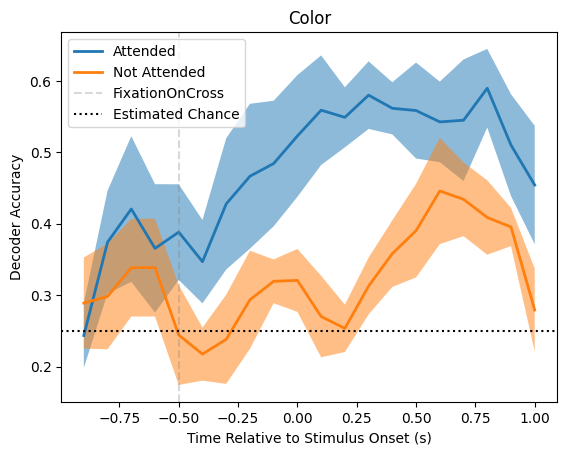

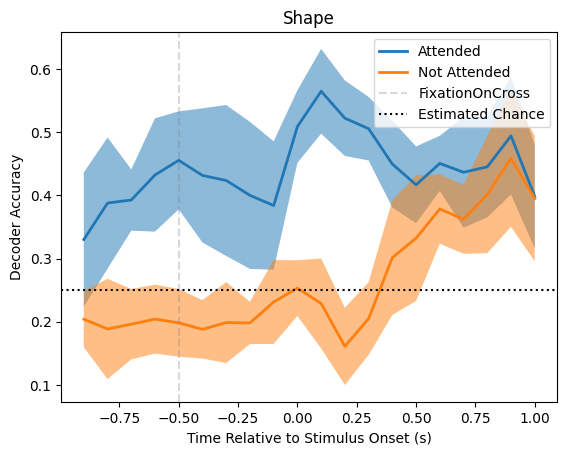

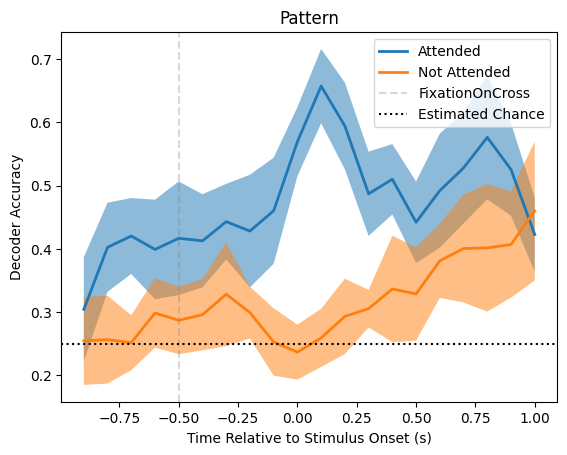

In [4]:
for dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_test_accs.npy"))
    not_attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_test_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Attended",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        not_attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Not Attended",
        right_align=True, 
    )
    # # add grey band for selection period
    # ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # # add dotted line for feedback start
    ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
    # # add estimated chance
    ax.axhline(1/4, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_title(dim)
    ax.legend()
    ax.set_xlabel("Time Relative to Stimulus Onset (s)")
    ax.set_ylabel("Decoder Accuracy")

In [5]:
attended_accs.shape

(20, 8)

### Attended vs. Shuffled dists

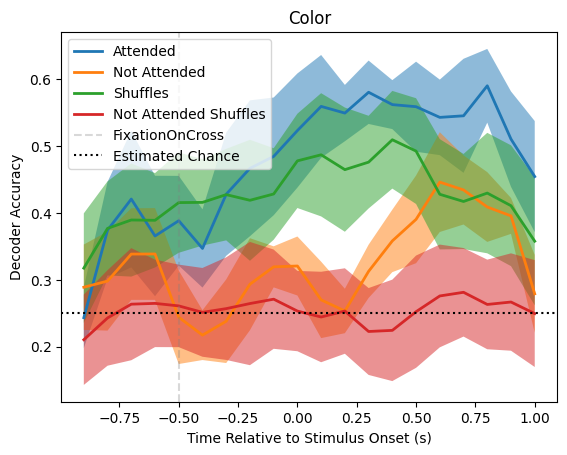

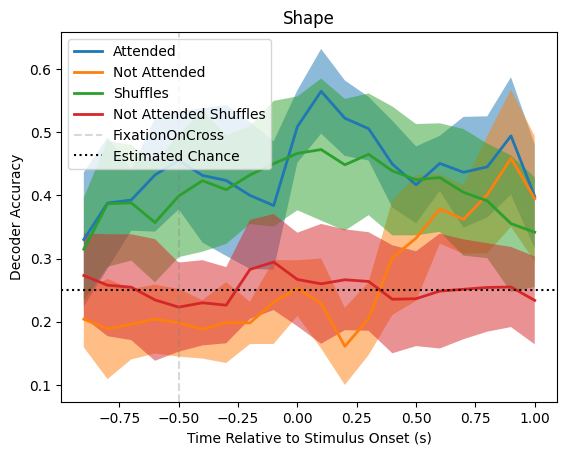

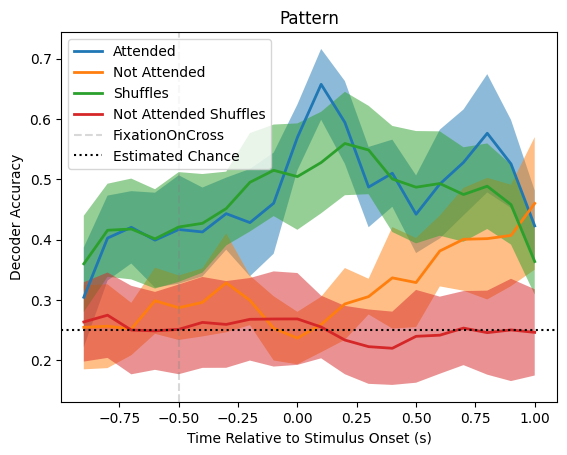

In [8]:
for dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_test_accs.npy"))
    not_attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_test_accs.npy"))

    shuffles = []
    not_attended_shuffles = []
    for i in range(5):
        shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_shuffle_{i}_test_accs.npy"))
        not_attended_shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_shuffle_{i}_test_accs.npy"))
        not_attended_shuffles.append(not_attended_shuffled_accs)
        shuffles.append(shuffled_accs)
    shuffles = np.hstack(shuffles)
    not_attended_shuffles = np.hstack(not_attended_shuffles)
    visualization_utils.visualize_accuracy_across_time_bins(
        attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Attended",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        not_attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Not Attended",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffles,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Shuffles",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        not_attended_shuffles,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Not Attended Shuffles",
        right_align=True, 
    )
    # # add grey band for selection period
    # ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # # add dotted line for feedback start
    ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
    # # add estimated chance
    ax.axhline(1/4, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_title(dim)
    ax.legend()
    ax.set_xlabel("Time Relative to Stimulus Onset (s)")
    ax.set_ylabel("Decoder Accuracy")

### Ask: on average: when are attended to or non-attended features significantly encoded?

In [6]:
attended_all = []
attended_shuffles = []
not_attended_all = []
not_attended_shuffles = []

for dim in FEATURE_DIMS:
    attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_test_accs.npy"))
    not_attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_test_accs.npy"))
    attended_all.append(attended_accs)
    not_attended_all.append(not_attended_accs)
    for i in range(5):
        attended_shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_attended_shuffle_{i}_test_accs.npy"))
        not_attended_shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_StimOnset_not_attended_shuffle_{i}_test_accs.npy"))

        attended_shuffles.append(attended_shuffled_accs)
        not_attended_shuffles.append(not_attended_shuffled_accs)
attended_all = np.hstack(attended_all)
not_attended_all = np.hstack(not_attended_all)
attended_shuffles = np.hstack(attended_shuffles)
not_attended_shuffles = np.hstack(not_attended_shuffles)


In [12]:
attended_all.shape

(20, 24)

In [33]:
from scipy import stats

def assess_significance(data, shuffle, alpha):
    """
    T Test for when means of data is signficantly different from means of a shuffle
    assume data has shape [time bins, observations]
    Returns boolean of length timebins
    """
    sigs = np.full((data.shape[0]), False, dtype=bool)
    for i in range(data.shape[0]):
        res = stats.ttest_ind(data[i], shuffle[i], equal_var=False, alternative="greater")
        if res.pvalue < alpha:
            sigs[i] = True
    return sigs

In [40]:
sigs_attended = assess_significance(attended_all, attended_shuffles, 0.01)
sigs_not_attended = assess_significance(not_attended_all, not_attended_shuffles, 0.01)

In [41]:
times = np.arange(-(PRE_INTERVAL / 1000), POST_INTERVAL / 1000, INTERVAL_SIZE / 1000) + INTERVAL_SIZE / 1000
sigs_attended_times = times[sigs_attended]
sigs_not_attended_times = times[sigs_not_attended]

Text(0, 0.5, 'Decoder Accuracy')

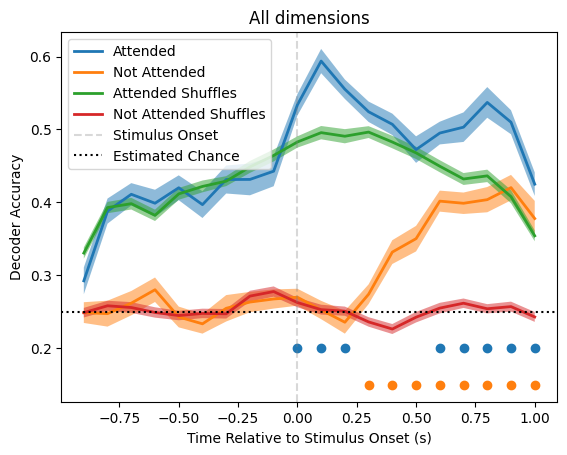

In [42]:
fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    attended_all,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Attended",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_attended_all,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Not Attended",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    attended_shuffles,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Attended Shuffles",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    not_attended_shuffles,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Not Attended Shuffles",
    right_align=True, 
    sem=True
)
ax.scatter(sigs_attended_times, np.ones(len(sigs_attended_times)) * 0.2, color="tab:blue")
ax.scatter(sigs_not_attended_times, np.ones(len(sigs_not_attended_times)) * 0.15, color="tab:orange")

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
ax.axvline(-0, alpha=0.3, color='gray', linestyle='dashed', label="Stimulus Onset")
# # add estimated chance
ax.axhline(1/4, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_title("All dimensions")
ax.legend()
ax.set_xlabel("Time Relative to Stimulus Onset (s)")
ax.set_ylabel("Decoder Accuracy")

### Time period around feedback onset

In [4]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze

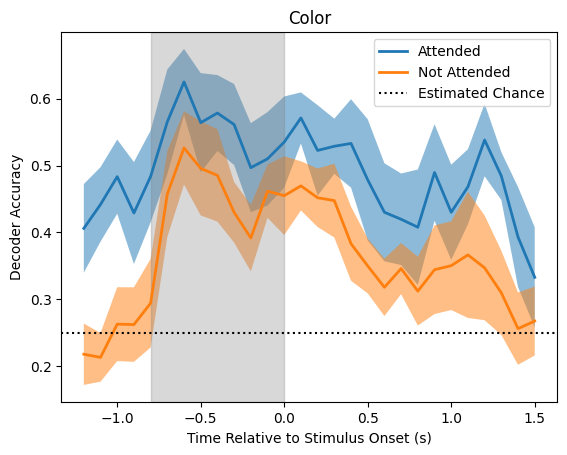

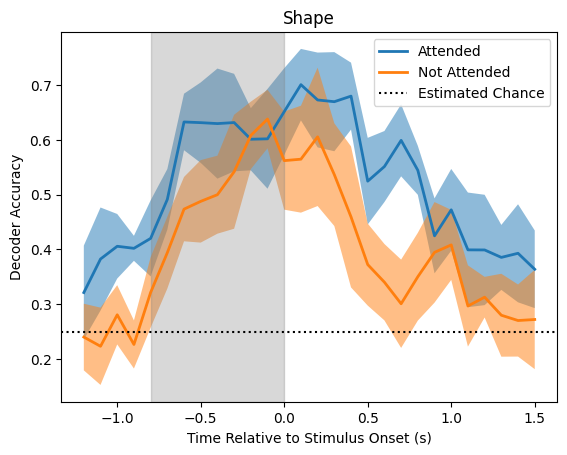

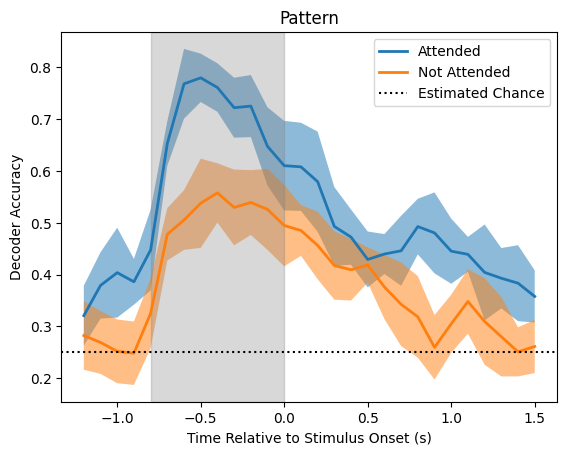

In [6]:
for dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_FeedbackOnset_attended_test_accs.npy"))
    not_attended_accs = np.load(os.path.join(OUTPUT_DIR, f"{dim}_FeedbackOnset_not_attended_test_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Attended",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        not_attended_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Not Attended",
        right_align=True, 
    )
    # # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # # add dotted line for feedback start
    # ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="FixationOnCross")
    # # add estimated chance
    ax.axhline(1/4, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_title(dim)
    ax.legend()
    ax.set_xlabel("Time Relative to Stimulus Onset (s)")
    ax.set_ylabel("Decoder Accuracy")